# The Auto Encoder
<!-- TODO: Give some info about what an autoencoder is and why its usefull -->
<!-- TODO: add and explain code for how to create and autoencoder, also describe how we used lightning to speed up on SLURM -->
I then trained the autoencoder on the dataset CIFAR10 for varying values of the number of latent dimensions on BluePebble. Let's now investigate our resulting models. First for an autoencoder with 512 latent dimensions. Let's first explore what the dataset looks like, we will now run some code chunks which will print out a grid of 4 of the images in CIFAR10 along with their labels:

In [16]:
# Do some imports from libraries and custom python scripts
import data
import matplotlib.pyplot as plt 
import torch.cuda as cuda 
import numpy as np
import torch
import torchvision

# We check the device
device = "cuda" if cuda.is_available() else "cpu"
print("Using device: ", device)

# Create the training and testing dataloaders and extract some images and their labels from the training set and test set
training_loader, test_loader = data.get_data_loader("CIFAR10", 64, device)
train_images, train_targets = next(iter(training_loader))
test_images, test_targets = next(iter(test_loader))

Using device:  cuda
Files already downloaded and verified
Files already downloaded and verified


In [2]:
# We will now create a function which given the targets will return the corresponding labels
def cifar10_label(target):
    """
    Returns the label for a given target value in the CIFAR10 dataset.
    """
    cifar10_labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    return [cifar10_labels[t] for t in target]

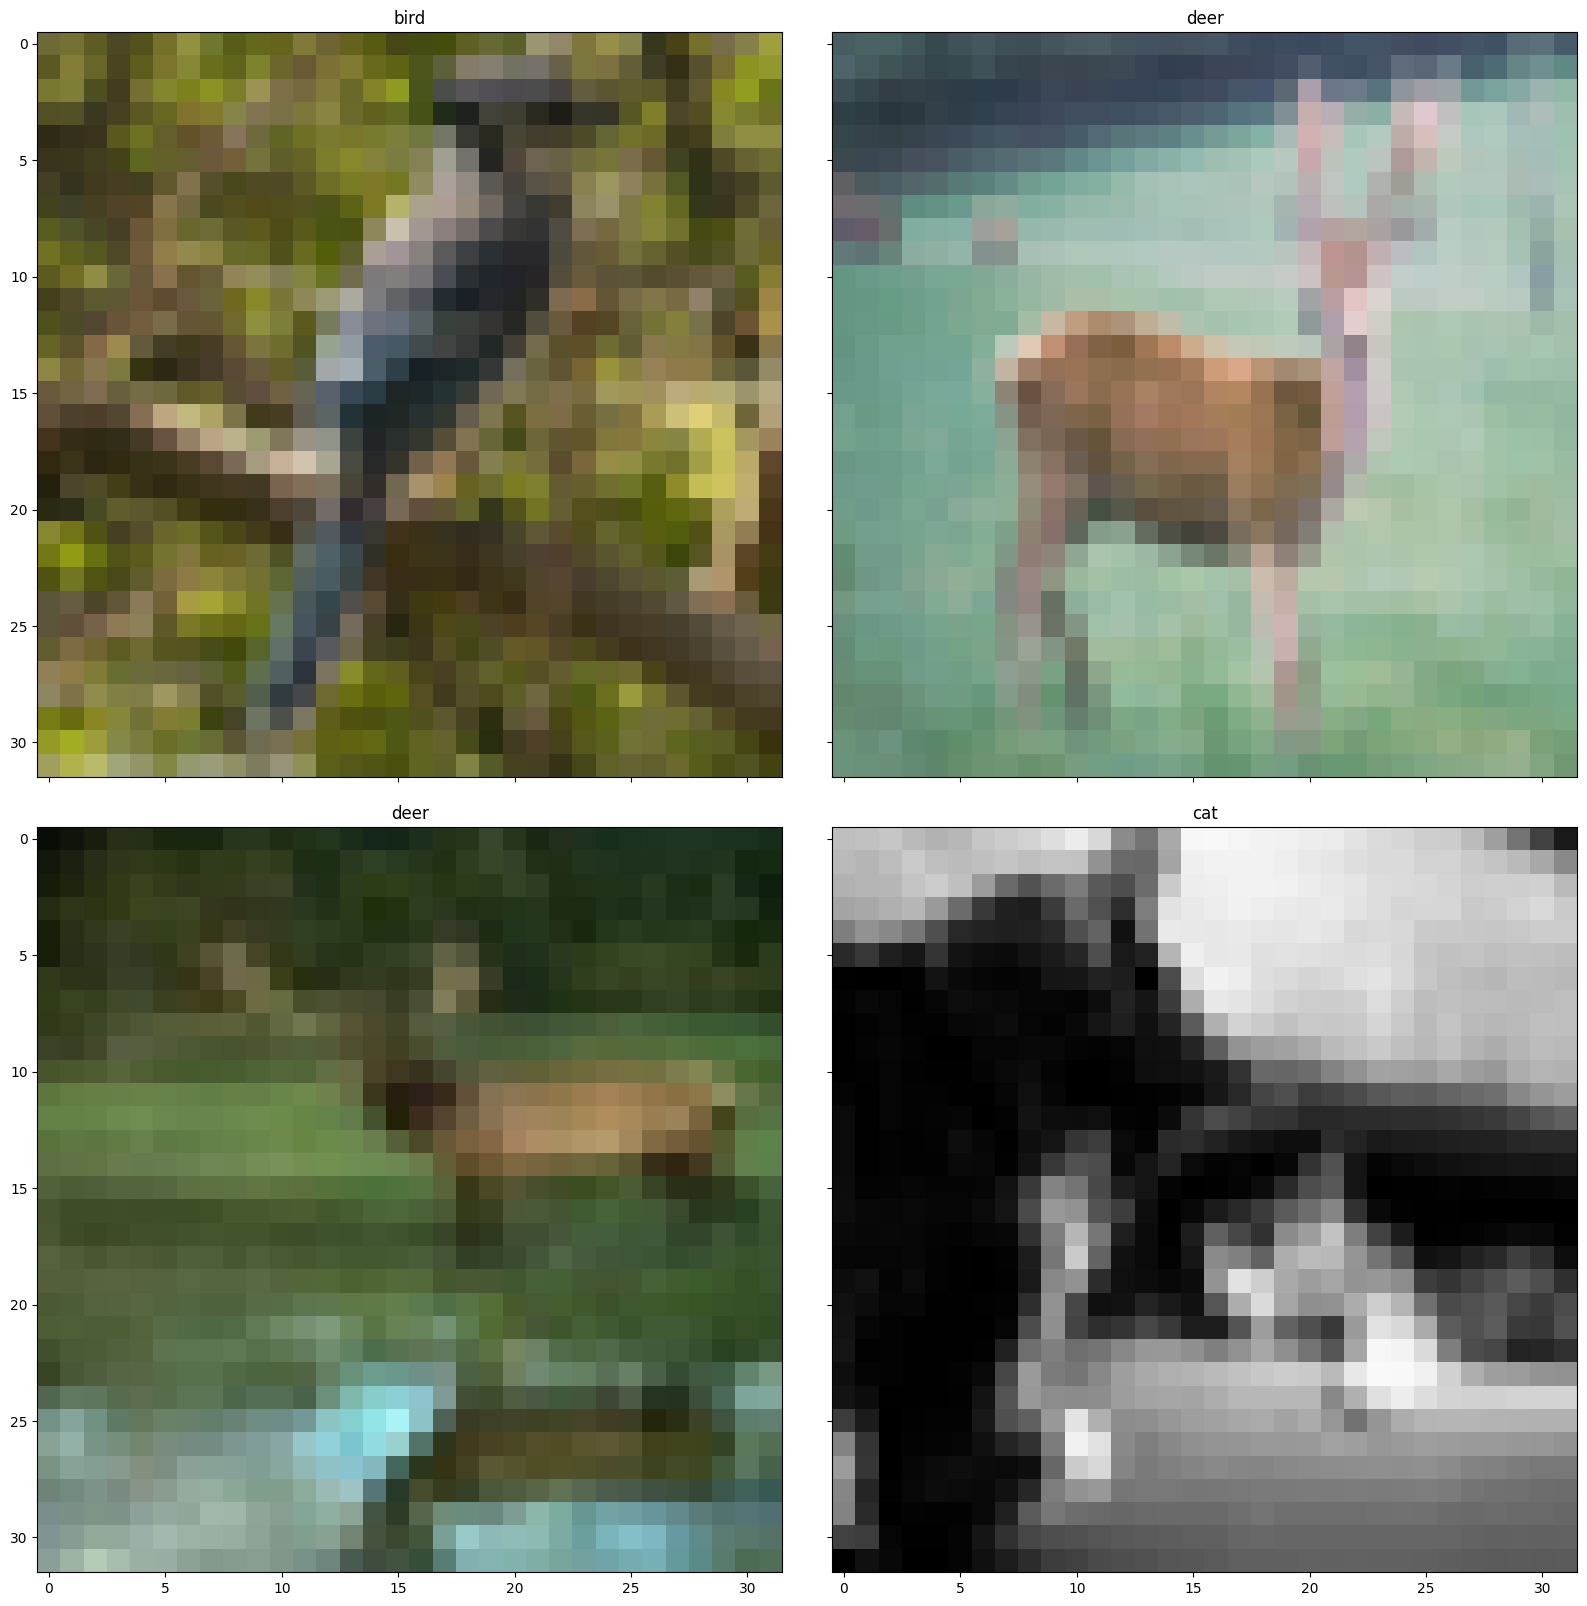

In [3]:
# Let's now print the image grid
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
labels = cifar10_label(train_targets[:4])
for i, (ax, im) in enumerate(zip(grid, train_images[:4])):
    ax.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    ax.set_title('{0}'.format(labels[i]))

plt.show()

Above we can see some of the images from CIFAR10 with their class label written above. Let's now run some images through the encoder part of the autoencoder and then through the decoder and plot our results:

In [4]:
!pip install pytorch-lightning
!pip install FastAPI

In [6]:
import VAE
# Load in our model that we trained on BluePebble
model = VAE.AutoEncoder.load_from_checkpoint("saved_models/autoencoder_512.ckpt")

# disable randomness, dropout, etc...
model.eval()

# Let's encode two of the images
encoded_images = model.encoder(train_images[:2])

# Let's now decode two of the images
decoded_images = model.decoder(encoded_images)



Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.1. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models/autoencoder_512.ckpt`


We've now encoded and decoded two of our images, let's plot our decoded images from the autoencoder against the original images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


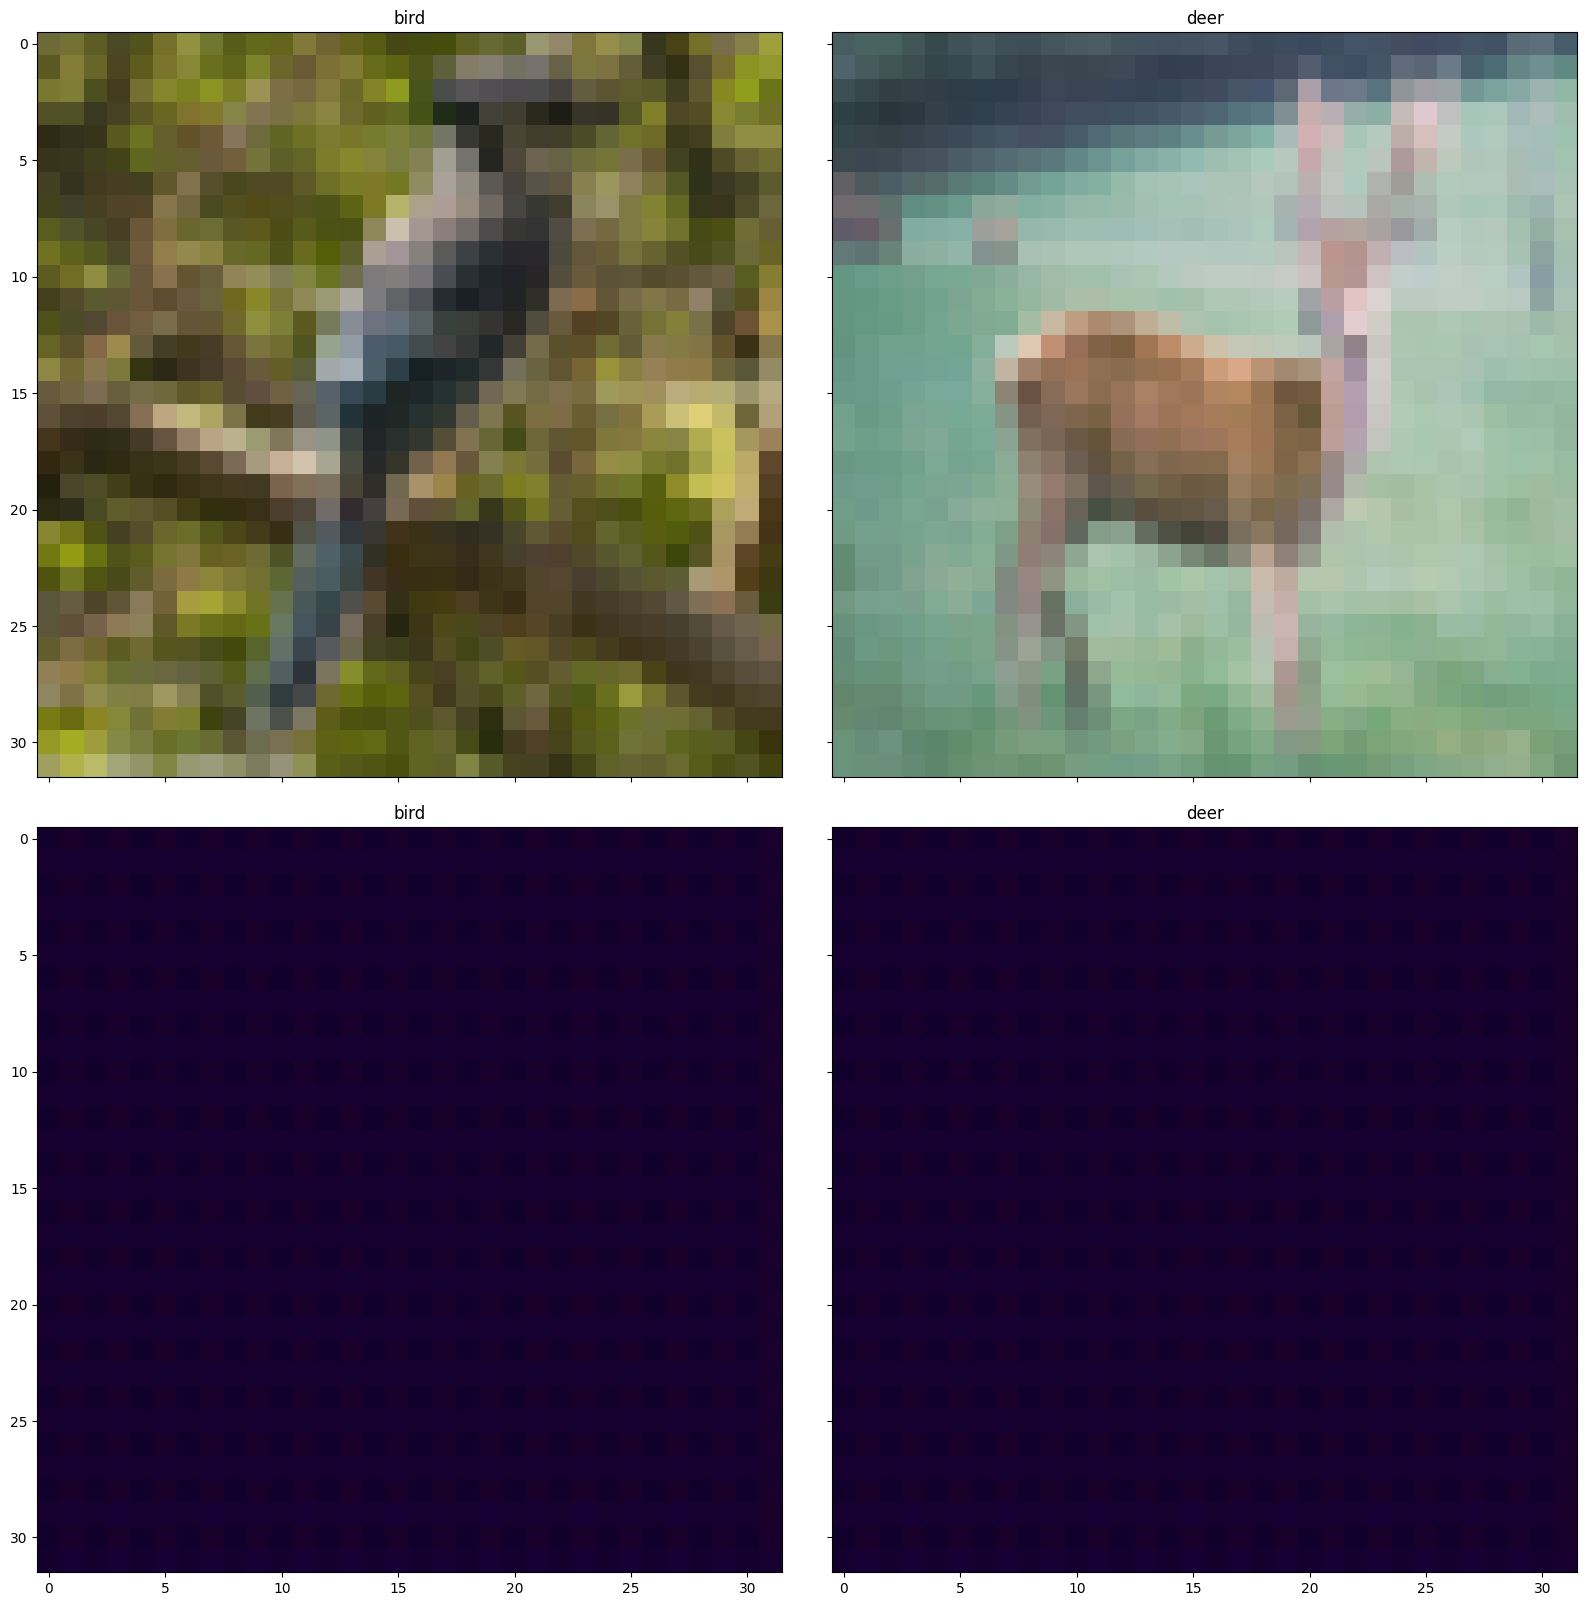

In [10]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
labels = cifar10_label(train_targets[:2])
for i, ax in enumerate(grid):
    if i==0 or i==1 :
        ax.imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i]))
    if i==2 or i==3:
        ax.imshow(np.transpose(decoded_images[i-2].detach().numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i-2]))

plt.show()

<!-- TODO: comment on the similarity between original (top) and decoded (bottom) -->
Let's now do the same but for models trained with differing sizes of latent dimensions:

In [ ]:
# TODO: Load in all the models you want to compare
# TODO: Add code here from lightning tutorial to create plot

Now we have examined what our decoded images look like in comparison to our original images, let's examine the encoding of the images. First let's examine what the latent space of our images looks like when we are using very small latent dimensions: